# Train a Quadcopter How to Fly
#  Using Reinforcement Learing
## By Yosry Negm

<br><hr><br>
This Project introduces how to Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm.

## <font color='grey'>Preparation and importing libraries</font>

In [1]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import random
import csv
import numpy as np
import sys
import pandas as pd

## <font color='grey'>Declerations of utility routines</font>

In [2]:
# function to 3D plot the changes in the quadcopter position
from mpl_toolkits.mplot3d import Axes3D
def quadcopter_3d_plot(results, vars=['x', 'y', 'z'], title=''):
    x = results[vars[0]]
    y = results[vars[1]]
    z = results[vars[2]]
    c = results['time']
    
    fig = plt.figure(figsize=(8, 4), dpi=100)
    ax = plt.axes(projection='3d')
    cax = ax.scatter(x, y, z, c=c, cmap='YlGn')
    ax.set(xlabel=vars[0], ylabel=vars[1], zlabel=vars[2], title=title)
    fig.colorbar(cax, label='Time step (s)', pad=0.1, aspect=40)
    plt.show();
    
# function to 3D plot the path of the Quadcopter

def show_flight_path(results, target=None):
    results = np.array(results)
    
    ax = plt.axes(projection='3d')
    ax.plot3D(results[:,0], results[:,1], results[:,2], 'gray')
    if not target is None:
        ax.scatter([target[0]], [target[1]], [target[2]], c='r', marker='o', s=30, label='Destination')
    ax.scatter(results[0,0], results[0,1], results[0,2], c='g', marker='x', s=30, label='Starting Point')
    ax.scatter(results[-1,0], results[-1,1], results[-1,2], c='b', marker='x', s=30, label='Ending point')
    ax.legend()

## <font color='grey'>Warm up</font>

In [3]:

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

The code below lets the agent select actions to control the quadcopter.  
The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [4]:
from task import Task

runtime = 10.                                     # time limit of the episode
init_pose = np.array([0., 0., 13., 0., 0., 18.])  # initial pose
init_velocities = np.array([0., 8., 10.])         # initial velocities
init_angle_velocities = np.array([0., 77., 31.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The code below visualizes how the position of the quadcopter evolved during the simulation.

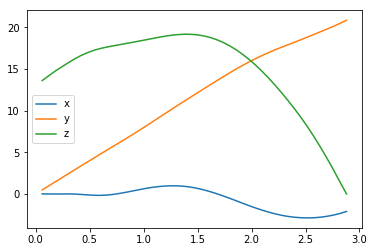

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

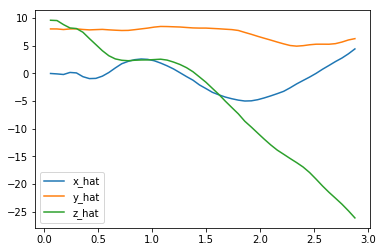

In [6]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, we can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

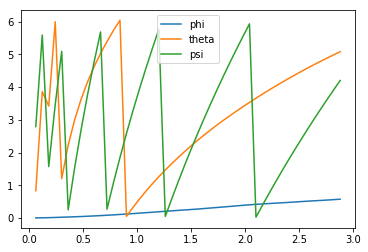

In [7]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

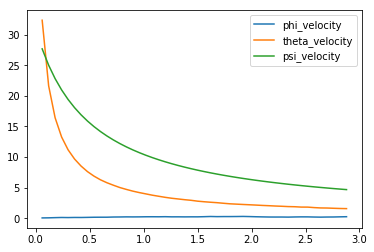

In [8]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, we can use the code cell below to print the agent's choice of actions.  

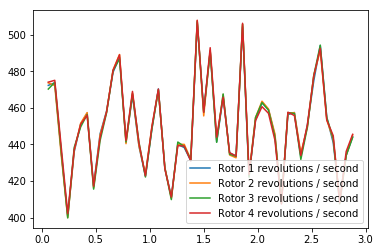

In [9]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, we will derive the environment state from the simulator.  The code below prints the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [10]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-2.10353833 20.8321708   0.          0.57451735  5.08255401  4.20241581]
[  4.43331897   6.29030472 -26.14553664]
[0.24594821 1.56689509 4.67426493]


### In adition, the following 3D plot visualize the changes in the Quadcopter position

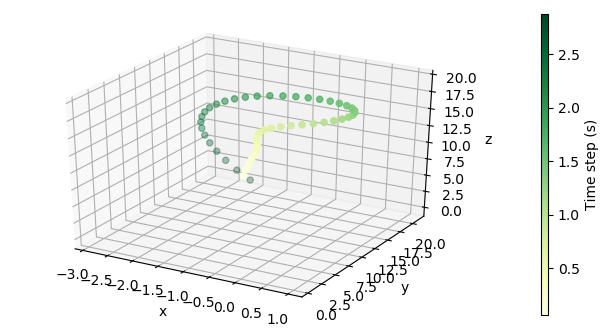

In [11]:
quadcopter_3d_plot(results, vars=['x', 'y', 'z'])

### Also, the following is a  3D plot to visualize the four rotors speed changes

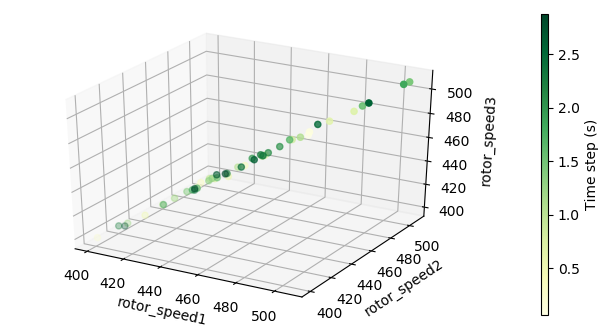

In [12]:
quadcopter_3d_plot(results, vars=['rotor_speed1', 'rotor_speed2', 'rotor_speed3'])

In `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending any more tasks, we could expand the size of the state vector by including the velocity information.  Also we can use any combination of the pose, velocity, and angular velocity.

## The Task

The `__init__()` method in `task.py` is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  we can see an example of this in the code below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, we will show how to test the performance of an agent on this task.

## The Agent

The agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

The code below explains how the agent performs on the task.

In [13]:
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 2000
target_pos = np.array([13., 8., 77.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 
rewards = []
labels = ['episode', 'total_reward']
results = {x : [] for x in labels}
best_flight_path = []
for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    flight_path = [ state ]
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        flight_path.append(state)
        if done:
            rewards += [agent.score]
            to_write = [i_episode] + [max(rewards)]
            for k in range(len(labels)):
                results[labels[k]].append(to_write[k])                 
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            rewards.append(np.mean(results['total_reward']))
            if agent.score >= max(rewards):
                best_flight_path = flight_path                
            break
    sys.stdout.flush()

Episode = 2000, score = -55.800 (best = -55.800), noise_scale = 3.25

This agent should <b>perform very poorly</b> on this task.  And that's where you come in! <font color='red'> As shown below :-</b>

In [14]:
# avrage  of the last 10 episodes
performance = np.mean(rewards[-10:])
print(performance)

-55.799999999999976


## Define the Task, Design the Agent, and Train Your Agent!

Now we will amend `task.py` to specify a task of our choosing.  If we're unsure what kind of task to specify, we may like to teach our quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying our task, we will use the agent in `agents/policy_search.py` as a template to define our new agent in `agents/agent.py`.  we can borrow whatever we need from the that agent, including ideas on how you might modularize our code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

## <font color='blue'>Take Off </font> Task

In [15]:
from agents.agent import DDPG
from task import Task,Task_TakeOff

num_episodes = 2000
target_pos = np.array([0., 0., 0.])
init_pos = np.array([0., 0., 0.])
task = Task_TakeOff(init_pose=init_pos, target_pos=target_pos)
rewards = []
labels = ['episode', 'total_reward']
results = {x : [] for x in labels}
agent = DDPG(task) 

best_flight_path = []
for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    num_steps = 0
    flight_path = [ state ]
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)
        state = next_state
        flight_path.append(state)
        if done:
            rewards += [agent.get_score()]
            to_write = [i_episode] + [max(rewards)]
            for k in range(len(labels)):
                results[labels[k]].append(to_write[k])            
            print("Episode = {:4d}, steps={:4d} reward = {:9.3f} (best = {:9.3f})  ".format(
                i_episode, agent.num_steps, agent.get_score(), max(rewards)), end="\r")  # [debug]
            rewards.append(np.mean(results['total_reward']))
            if agent.get_score() >= max(rewards):
                best_flight_path = flight_path                
            break
            
    sys.stdout.flush()

Using TensorFlow backend.


## Ploting rewards for Take Off Task

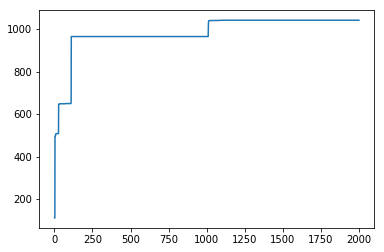

In [16]:
plt.plot(results['episode'], results['total_reward'])
_ = plt.ylim()

## Average of the last 10 episodes

In [17]:
# avrage  of the last 10 episodes
performance = np.mean(rewards[-10:])
print(performance)

769.4499606434813


## <font color='blue'>Hover </font> Task

In [18]:
from agents.agent import DDPG
from task import Task_Hover


# the values below gives the quadcopter different starting positions.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 0., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'rewards.txt'                      # file name for saved results

num_episodes = 2000
target_pos = np.array([0., 0., 0.])
task = Task(target_pos=target_pos)
agent = DDPG(task) 
rewards = []
labels = ['episod', 'total_reward']
results = {x : [] for x in labels}

with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)  
    best_total_reward = 0
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode
        total_reward = 0
        while True:
            action = agent.act(state) 
            next_state, reward, done = task.step(action)
            total_reward += reward
            if total_reward > best_total_reward:
                best_total_reward = total_reward
            agent.step(action, reward, next_state, done)
            state = next_state
            if done:
                to_write = [i_episode] + [total_reward]
                for ii in range(len(labels)):
                    results[labels[ii]].append(to_write[ii])
                writer.writerow(to_write)
                print("\rEpisode = {:4d}, total_reward = {:7.3f} (best = {:7.3f})".format(
                    i_episode, total_reward, best_total_reward), end="")
                rewards.append(np.mean(results['total_reward']))
                break
        sys.stdout.flush()

Episode = 2000, total_reward =  14.542 (best =  54.738))

## Ploting rewards for Hover Task

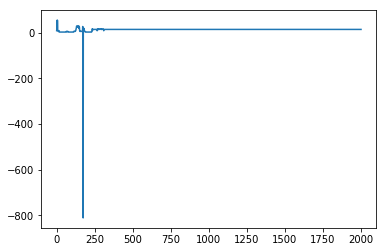

In [19]:
plt.plot(results['episod'], results['total_reward'])
_ = plt.ylim()

## Average of the last 10 episodes

In [20]:
# avrage  of the last 10 episodes
performance = np.mean(rewards[-10:])
print(performance)

13.000467368896963


## Reflections

I have chosen two tasks to train my designed agent, they are <b><font color='green'> Take-off task</font></b> and <b><font color='green'> Hover task</font></b> . I designed the reward function in both cases to <b>preserve the clipping of rewards between -1 and +1</b> trying to to<b> maximize the penality</b> whenever the distance between the pose and target of the quadcopter is large or the agent has run out of time.


In this project, I chose to use<font color='green'><b> Actor-Critic Algorithm </b></font>to train my dsigned agent on the prposed tasks. It works better for me after tuning the algorithm hyper parameter such as 
choosing discount factor (<font color='green'><b>gamma</b></font>) equal to 0.99 and <font color='green'><b>epislon</b></font> equal to 0.01 for <b>soft update of target parameters</b>.<br>
I build the model by<b> two nural networks </b>one for the <u>actor</u> and the other one for the <u>crictic</u> with  <font color='green'><b>ReLu</b></font> activation function in the hidden layers and <font color='green'><b>Sigmoid </b></font>activation function in the output layer in each.<br>
- <b><u>The Neural Network of the Actor</u></b> :-<br>
    -  Dense :  32 hidden units Layer ,Two Layers with 64 hidden units each , 128 hidden units Layer (All with <b>ReLu</b> activation function) and Batch Normalization. 
    -  Dropout: 3 with keep_prob = 0.5 .
    -  Output : on Layer with units equal to the action size with <b>Sigmoid</b> activation function.<br>
- <b><u>The Neural Network of the Critic</u></b>:-<br>
    - <b><u>State </u>:</b> <br>
        -  Dense :  32 hidden units Layer , 64 hidden units Layer, 128 hidden units Layer (All with <b>ReLu</b> activation function) and Batch Normalization. 
        -  Dropout: 3 with keep_prob = 0.5.<br>
    - <b><u>Action </u>:</b><br>
        -  Dense : Two Layers with 64 hidden units each, 128 hidden units Layer (All with <b>ReLu</b> activation function) and Batch Normalization. 
        -  Dropout: 3 with keep_prob = 0.5.<br>
- <p>When building this architecture, I put into consideration imporving policy gradient with a critic i.e running the policy over generating samples then fit the model to estimate the return and therefore, improving the policy.The used algorithms seems to be stable and simple despite of there is no shared features between the actor and the critic so I made it to work in Batch to get lower variance with virtue of critic trying to get rewards sooner as possible to obtain better performance.</p>

Training the agent to fly the Quadcopter wasn't easy task, It took me extra time and lots of trail and error ,gussing and numerous tuning phases of the hyperparamers of the algorithm and the architecture as well as trying different intial states and redesigning the reward function several times until got gradual learning curve and better performance as indicated from the mean of the last 10 episodes.

First of all it was an excited experience for me, especially I am interested in the programming of autonomous vehicles. The project was a great chance to have hands and dig into field
more practically,The hardest part I faced was really how to define and design tasks it tooks me time to think about them also I found some difficulty in tuning the parameters and reward function to get better performance as well as inspecting the architecture serveral times.Plotting results was so easy and the project in general goes smooth with me.